<a href="https://colab.research.google.com/github/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Convolutional Sequence to Sequence Learning

В этой части мы будем реализовывать модель из статьи [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122).

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq0.png?raw=1)

## Введение

Эта модель кардинально отличается от предыдущих моделей, реализованных нами. Здесь вообще не используются рекуррентные компоненты. Вместо этого применяются свёрточные слои (CNN), обычно применяемые для обработки изображений. В качестве введения в особенности использования свёрточных слоёв для обработки текста см. руководство [здесь](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb).


Если коротко, то свёрточный слой использует *фильтры*. Эти фильтры имеют *ширину* (а также *высоту* в изображениях, но обычно не для текстов). Если фильтр имеет ширину 3, он может видеть 3 последовательных токена. Каждый свёрточный слой имеет множество таких фильтров (1024 в этом разделе). Каждый фильтр будет скользить по последовательности от начала до конца, просматривая все 3 последовательных токена одновременно. Идея состоит в том, что каждый из этих 1024 фильтров научится извлекать из текста разные признаки. Результат этого извлечения признаков будет затем использоваться моделью — потенциально в качестве входных данных для другого свёрточного слоя. Затем всё это можно использовать для извлечения особенностей из исходного предложения для перевода его на целевой язык.


## Подготовка данных

Во-первых, давайте импортируем все необходимые модули и зададим случайные начальные числа для воспроизводимости.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Для загрузки в Google Colab используем следующие команды (После загрузки обязательно перезапустите colab runtime! Наибыстрейший способ через короткую комаду： **Ctrl + M + .**):

In [ ]:
!pip install -U spacy==3.0
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Затем мы загрузим модели spaCy и определим токенизаторы для исходного и целевого языков.

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Далее мы настроим `Field` которые решают, как будут обрабатываться данные. По умолчанию модели RNN в PyTorch требуют, чтобы последовательность была тензором формы **[sequence length, batch size]** поэтому TorchText по умолчанию возвращает пакеты тензоров той же формы. Однако в этой части мы используем CNN, которая ожидают, что размер пакета будет первым. Мы говорим TorchText, что партии должны быть **[batch size, sequence length]** установив `batch_first = True`.

Мы также добавляем токены начала и конца последовательности, и переводим весь текст в нижний регистр.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Затем мы загружаем наш набор данных.

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), 
                                                    fields=(SRC, TRG))

Мы, как и раньше, пополняем наш словарь, конвертируя любые токены, которые встречаются менее двух раз, в `<unk>` токены.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Последний этап подготовки данных — определение устройства, а затем создание итератора.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Построение модели

Следующим шагом будет построение модели. Как и прежде, модель состоит из кодировщика и декодера. Кодировщик *кодирует* вводное предложение, на исходном языке, в *вектор контекста*. Декодер *декодирует* вектор контекста для создания выходного предложения на целевом языке.

### Кодировщик

Предыдущие модели в этих уроках имели кодировщик, который сжимает всё входное предложение в один вектор контекста $z$. Свёрточная модель sequence-to-sequence немного отличается — она получает два вектора контекста для каждого токена во входном предложении. Итак, если бы в нашем входном предложении было 6 токенов, мы получили бы 12 контекстных векторов, по два на каждый токен.

Два вектора контекста на токен - это *преобразованный* вектор и *комбинированный* вектор. Преобразованный вектор - это результат прохождения каждого токена через несколько слоев, работу которых мы вскоре объясним. Комбинированный вектор получается в результате суммирования вектора, прошедшего свёрточные слои, и эмбеддинга этого токена. Оба они возвращаются кодером для использования декодером.

На изображении ниже показан результат ввода предложения - *zwei menschen fechten.* - которое проходит через кодировщик.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq1.png?raw=1)

Сначала токен проходит через *слой эмбеддинга токенов* - что является стандартом для нейронных сетей обработки естественного языка. Однако, поскольку в этой модели нет рекуррентой части, то она не имеет представления о порядке токенов в последовательности. Чтобы исправить это, у нас есть второй слой эмбеддинга, *позиционный слой эмбеддинга*. Это стандартный уровень эмбеддинга, где входом является не сам токен, а позиция токена в последовательности - начиная с первого токена, токена `<sos>` (начало последовательности), в позиции 0.

Затем токен и позиционные эмбеддинги поэлементно суммируются, чтобы получить вектор, который содержит информацию о токене, а также его позицию в последовательности, которую мы будем называть *вектор эмбеддинга*. Затем следует линейный слой, который преобразует вектор эмбеддинга в вектор с требуемым размером скрытого слоя.

Следующий шаг - передача этого скрытого вектора в $N$ *свёрточных блоков*. Именно здесь в этой модели происходит вся «магия», и вскоре мы подробно рассмотрим содержимое свёрточных блоков. После прохождения свёрточных блоков вектор затем проходит через другой линейный слой, чтобы преобразовать его обратно из размера скрытого слоя к размеру выхода эмбеддинга. Это наш *преобразованный* вектор - по одному для каждого токена во входной последовательности.

Наконец, преобразованный вектор поэлементно суммируется с вектором эмбеддинга через остаточное соединение, чтобы получить *комбинированный* вектор для каждого токена. Опять же, имеется комбинированный вектор для каждого токена во входной последовательности.

### Свёрточные блоки

Итак, как работают эти свёрточные блоки? На изображении ниже показаны 2 свёрточных блока с одним фильтром (синий), который скользит по токенам в последовательности. В реальной реализации у нас будет 10 свёрточных блоков с 1024 фильтрами в каждом блоке.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq2.png?raw=1)

Сначала вводимое предложение необходимо дополнить. Это связано с тем, что свёрточные слои уменьшают длину входного предложения, и мы хотим, чтобы длина предложения, входящего в свёрточные блоки, равнялась его длине по выходу из свёрточных блоков. Без заполнения длина последовательности, выходящей из свёрточного слоя, будет `filter_size - 1` элементов короче, чем последовательность, входящая в свёрточный слой. Например, если бы у нас был размер фильтра 3, последовательность будет на 2 элемента короче. Таким образом, мы дополняем предложение одним элементом заполнения с каждой стороны. Мы можем рассчитать количество отступов с каждой стороны, просто выполнив `(filter_size - 1)/2` для фильтров нечетного размера - в этой части мы не будем рассматривать фильтры четного размера.

Эти фильтры разработаны таким образом, чтобы их скрытый размер вывода был вдвое больше, чем скрытый размер ввода. В терминологии компьютерного зрения эти скрытые измерения называются *каналами* - но мы будем называть их скрытыми измерениями. Почему мы удваиваем размер скрытого измерения, покидая свёрточный фильтр? Это потому, что мы используем специальную функцию активации, которая называется *закрытые линейные блоки* (gated linear units - GLU). У GLU есть затворные механизмы (похожие на LSTM и GRU), содержащиеся в функции активации и, фактически, вдвое меньшие размера скрытого измерения, тогда как обычно функции активации сохраняют скрытые измерения того же размера.

После прохождения активации GLU размер скрытого измерения для каждого токена такой же, как и при входе в свёрточные блоки. Теперь он поэлементно суммируется со своим собственным вектором, прежде чем он будет пропущен через следующий свёрточный слой.

На этом завершается одиночный свёрточный блок. Последующие блоки берут вывод предыдущего блока и выполняют те же шаги. У каждого блока есть свои параметры, они не разделяются между блоками. Вывод последнего блока возвращается в основной кодировщик — где он проходит через линейный слой для получения преобразованного вывода, а затем поэлементно суммируется с токеном эмбеддига для получения комбинированного вывода.


### Реализация кодировщика

Чтобы упростить реализацию, мы допускаем только ядра нечётного размера. Это позволяет добавлять одинаковые отступы к обеим сторонам исходной последовательности.

Переменная величина `scale` используется авторами, чтобы «гарантировать, что дисперсия во всей сети не изменится кардинально». Производительность модели может сильно различаться, если не использовать данное ухищрение.

Позиционный эмдеддинг инициализируется так, чтобы иметь "словарь" 100. Это означает, что он может обрабатывать последовательности длиной до 100 элементов с индексами от 0 до 99. Его можно увеличить, если использовать в наборе данные с большей длиной последовательностей.

In [10]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

### Декодер

Декодер принимает фактическое целевое предложение и пытается его предсказать. Эта модель отличается от моделей рекуррентных нейронных сетей, описанных ранее, тем, что она прогнозирует все токены в целевом предложении параллельно. Нет последовательной обработки, то есть цикла декодирования. Это будет подробно описано позже.

Декодер похож на кодировщик, с некоторыми изменениями как в основной модели, так и в свёрточных блоках внутри модели.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq3.png?raw=1)

Во-первых, эмбеддинги не имеют остаточной связи, которая соединяется после свёрточных блоков и преобразования. Вместо этого эмбеддинги подаются в свёрточные блоки, которые будут использоваться там в качестве остаточных соединений.

Во-вторых, для подачи информации декодеру от кодера используются преобразованные и комбинированные выходные данные кодера — опять же, в свёрточных блоках.

Наконец, выход декодера представляет собой линейный слой от размера эмбеддинга до размера вывода. Это используется для предсказания того, каким должно быть следующее слово в переводе.

### Свёрточные блоки декодера

Они похожи на свёрточные блоки в кодировщике с некоторыми изменениями.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq4.png?raw=1)

Во-первых, дополнения. Вместо того, чтобы заполнять одинаково с каждой стороны, чтобы длина предложения оставалась неизменной на всем протяжении, мы выполняем заполнение только в начале предложения. Поскольку мы обрабатываем все целевые токены одновременно параллельно, а не последовательно, нам нужен метод, позволяющий фильтрам, переводящим токен $i$, смотреть только на токены перед словом $i$. Если бы им было разрешено смотреть на $i+1$-ый токен (токен, который они должны выводить), то модель просто научилась бы предоставлять следующее слово в последовательности напрямую, копируя его, фактически не обучаясь переводить.

Давайте посмотрим, что произойдет, если мы **неправильно** сделали добавления с каждой стороны, как в кодировщике.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq5.png?raw=1)

Фильтр в первой позиции, который пытается использовать первое слово в последовательности `<sos>`, чтобы предсказать второе слово, `two`, теперь может напрямую видеть слово` two`. Это слово для каждой позиции, которое модель пытается предсказать, является вторым элементом, охваченным фильтром. Таким образом, фильтры могут научиться просто копировать второе слово в каждой позиции, обеспечивая идеальный перевод, фактически не изучая, как переводить.

Во-вторых, после активации GLU и до остаточного соединения блок вычисляет и применяет внимание - используя закодированные представления и эмбеддинг текущего слова. **Замечание**: мы показываем соединения только с крайним правым токеном, но на самом деле они охватывают все токены (пример приведён только для ясности проблемы). Каждый входной токен использует свои собственные и только свои эмбеддинги для расчёта собственного внимания.

Внимание рассчитывается путем использования сначала линейного слоя, для изменения скрытого размера на тот же размер, что и размер эмбеддинга. Затем эмбеддинг суммируется с помощью остаточного соединения. Затем к этой комбинации применяется стандартный расчет внимания путем нахождения того, насколько оно «совпадает» с *закодированным преобразованным вектором*, а затем это применяется путем получения взвешенной суммы по *закодированному объединенному вектору*. Затем эта спроецированная копия до размера скрытого измерения и применяется остаточная связь с начальным входом к слою внимания.

Почему они сначала вычисляют внимание с закодированным преобразованным вектором, а затем используют его для вычисления взвешенной суммы по закодированному комбинированному векторы? В статье утверждается, что закодированный преобразованный код хорош для получения более широкого контекста по сравнению с закодированной последовательностью, тогда как закодированный комбинированный вектор содержит больше информации о конкретном токене и, следовательно, более полезен для создания прогноза.

### Реализация декодера

Поскольку мы дополняем только одну сторону, декодеру разрешено использовать заполнение как нечетного, так и четного размера. Опять же, `scale` используется для уменьшения дисперсии по всей модели, а встраивание позиции инициализируется, чтобы иметь «словарь» равный 100.

Эта модель принимает представления кодировщика в свой метод `forward`, результат и аргумент - оба передаются в метод `calculate_attention`, который рассчитывает и применяет механизм внимания. Он также возвращает фактические значения внимания, но в настоящее время мы их не используем.

In [11]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Seq2Seq

Инкапсулирующий модуль Seq2Seq сильно отличается от методов рекуррентной нейронной сети, используемых в предыдущих разделах, особенно при декодировании.

У нашего `trg` элемент `<eos> `отрезан от конца последовательности потому, что мы не вводим токен `<eos>` в декодер.

Кодирование аналогично предыдущим разделам, вставляем исходную последовательность и получаем «вектор контекста». Однако здесь у нас есть два вектора контекста на одно слово в исходной последовательности, `encoder_conved` и `encoder_combined`.

Поскольку декодирование выполняется параллельно, нам не нужен цикл декодирования. Вся целевая последовательность сразу вводится в декодер, а заполнение используется для обеспечения того, чтобы каждый свёрточный фильтр в декодере мог видеть только текущий и предыдущий токены в последовательности, когда он скользит по предложению.

Однако это также означает, что мы не можем применять обучение с принуждением, используя эту модель. У нас нет цикла, в котором мы можем выбрать, вводить ли предсказанный токен или фактический токен в последовательности, поскольку все предсказывается параллельно.

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

## Обучение модели Seq2Seq

Остальная часть раздела аналогична всем предыдущим. Мы определяем все гиперпараметры, инициализируем кодер и декодер, а также инициализируем общую модель - размещая ее на графическом процессоре, если он у нас есть.

В статье авторы считают, что более выгодно использовать небольшой фильтр (размер ядра 3) и большое количество слоев (5+).

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

Мы также можем видеть, что модель имеет почти вдвое больше параметров, чем модель, основанная на внимании (от 20 до 37 метров).

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,173 trainable parameters


Далее мы определяем оптимизатор и функцию потерь (критерий). Как и раньше, мы игнорируем потери, когда целевая последовательность является маркером заполнения.

In [15]:
optimizer = optim.Adam(model.parameters())

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Затем мы определяем цикл обучения модели.

Мы обрабатываем последовательности немного иначе, чем в предыдущих уроках. Для всех моделей мы никогда не помещаем `<eos>` в декодер. В моделях RNN это объяснялось тем, что цикл декодера останавливается при достихении значения `<eos>` в качестве входа для декодера. В этой модели мы просто отрезаем токен `<eos>` от конца последовательности. Таким образом:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ обозначает фактический элемент целевой последовательности. Затем мы вводим это в модель, чтобы получить предсказанную последовательность, которая, как мы надеемся, должна предсказывать токен `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ обозначает предсказанный элемент целевой последовательности. Затем мы вычисляем наши потери, используя исходный тензор `trg` с токеном `<sos> `, отрезанным спереди, оставляя токен `<eos> `:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

Затем мы рассчитываем наши потери и обновляем наши параметры, как это обычно делается.

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Цикл оценки такой же, как цикл обучения, только без вычислений градиента и обновления параметров.

In [18]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Опять же, у нас есть функция, которая сообщает нам, сколько времени занимает каждая эпоха.

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Наконец, мы обучаем нашу модель. Обратите внимание, что мы уменьшили значение CLIP с 1 до 0.1, чтобы обучить эту модель более точно. При более высоких значениях «CLIP» градиент иногда резко увеличивается.

Хотя у нас почти в два раза больше параметров, чем у модели RNN, основанной на внимании, на самом деле она обучение занимает примерно половину времени от стандартной версии, и примерно столько же, как в версии упакованных дополненных последовательностей. Это связано с тем, что все вычисления выполняются параллельно с использованием свёрточных фильтров вместо последовательного использования RNN.

**Замечание**: эта модель всегда имеет коэффициент для обучения с принуждением равный 1, то есть всегда будет использоваться истинное значение для следующего токена из целевой последовательности. Это означает, что мы не можем сравнивать значения точности с предыдущими моделями, в которых использовался коэффициент обучения с принуждением отличный от 1. Смотрите [здесь](https://github.com/bentrevett/pytorch-seq2seq/issues/39#issuecomment-529408483) для результатов RNN, основанной на внимании, с использованием коэффициента обучения с принуждением равным 1.

In [20]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 58s
	Train Loss: 4.165 | Train PPL:  64.386
	 Val. Loss: 2.876 |  Val. PPL:  17.736
Epoch: 02 | Time: 1m 3s
	Train Loss: 2.965 | Train PPL:  19.396
	 Val. Loss: 2.342 |  Val. PPL:  10.402
Epoch: 03 | Time: 1m 2s
	Train Loss: 2.567 | Train PPL:  13.027
	 Val. Loss: 2.127 |  Val. PPL:   8.387
Epoch: 04 | Time: 1m 3s
	Train Loss: 2.343 | Train PPL:  10.408
	 Val. Loss: 1.987 |  Val. PPL:   7.292
Epoch: 05 | Time: 1m 2s
	Train Loss: 2.192 | Train PPL:   8.949
	 Val. Loss: 1.914 |  Val. PPL:   6.777
Epoch: 06 | Time: 1m 3s
	Train Loss: 2.081 | Train PPL:   8.010
	 Val. Loss: 1.886 |  Val. PPL:   6.593
Epoch: 07 | Time: 1m 2s
	Train Loss: 1.992 | Train PPL:   7.333
	 Val. Loss: 1.828 |  Val. PPL:   6.225
Epoch: 08 | Time: 1m 2s
	Train Loss: 1.923 | Train PPL:   6.840
	 Val. Loss: 1.820 |  Val. PPL:   6.170
Epoch: 09 | Time: 1m 3s
	Train Loss: 1.859 | Train PPL:   6.417
	 Val. Loss: 1.773 |  Val. PPL:   5.886
Epoch: 10 | Time: 1m 2s
	Train Loss: 1.805 | Train PPL:   6.078

Затем мы загружаем параметры, которые имеют наименьшие потери при проверке, и вычисляем потери по набору тестов.

In [21]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.821 | Test PPL:   6.176 |


## Вывод

Теперь мы можем переводить с помощью нашей модели использую функцию `translate_sentence` ниже.

Выполняются следующие шаги при переводе:
- токенизируем исходное предложение, если оно не было токенизировано (является строкой)
- добавляем токены `<sos>` и `<eos>`
- нумеруем исходное предложение
- преобразовываем его в тензор и добавляем размер батча
- передаём исходное предложение в кодировщик
- создаём список для хранения выходного предложения, инициализированного токеном `<sos>`
- пока мы не достигли максимальной длины
  - преобразуем текущий прогноз выходного предложения в тензор с размерностью батча
  - поместим текущий выход и два выхода кодировщика в декодер
  - получим предсказание следующего выходного токена от декодера
  - добавим предсказание к предсказанию текущего выходного предложения
  - прерываем, если предсказание было токеном `<eos>`
- преобразоваем выходное предложение из индексов в токены
- возвращаем выходное предложение (с удаленным токеном `<sos>`) и вектор внимания с последнего слоя

In [22]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Затем у нас есть функция, которая будет отображать, насколько модель обращает внимание на каждый входной токен на каждом этапе декодирования.

In [23]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Затем мы, наконец, начнем переводить несколько предложений.

Сначала возьмем пример из обучающей выборки:

In [24]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


Затем мы передаем его в нашу функцию `translate_sentence`, которая дает нам предсказанные токены перевода, а также вектор внимания.

Мы видим, что наша модель неправильно переводит *wooden* как *plastic*.

In [26]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'is', 'climbing', 'a', 'playhouse', 'in', 'a', 'playhouse', '.', '<eos>']


Мы можем наблюдать за вниманием модели, чтобы убедиться, что она дает точный результат.

Мы видим, что он обращает внимание на *spielhaus* при создании токенов *plastic* и *playhouse*.

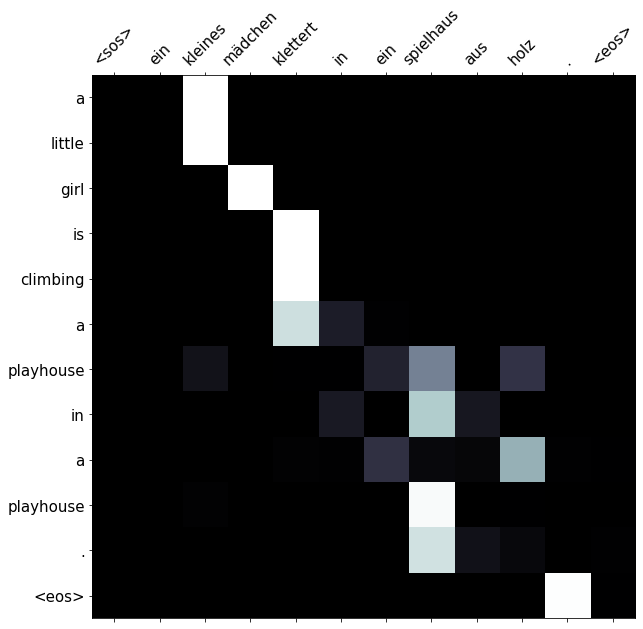

In [27]:
display_attention(src, translation, attention)

Посмотрим, насколько хорошо он переводит пример, которого нет в обучающей выборке.

In [28]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


Модель хорошо справляется с этой задачей.

In [29]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'with', 'headphones', 'sits', 'on', 'her', 'shoulders', 'of', 'a', 'woman', "'s", 'shoulders', '.', '<eos>']


Опять же, мы можем видеть, что внимание уделяется разумным словам - *junge* для *boy*, *einer* для *of* и *a*, и т. Д. Как ни странно, внимание при декодировании токена `<eos>` фокусируется на *frau*.

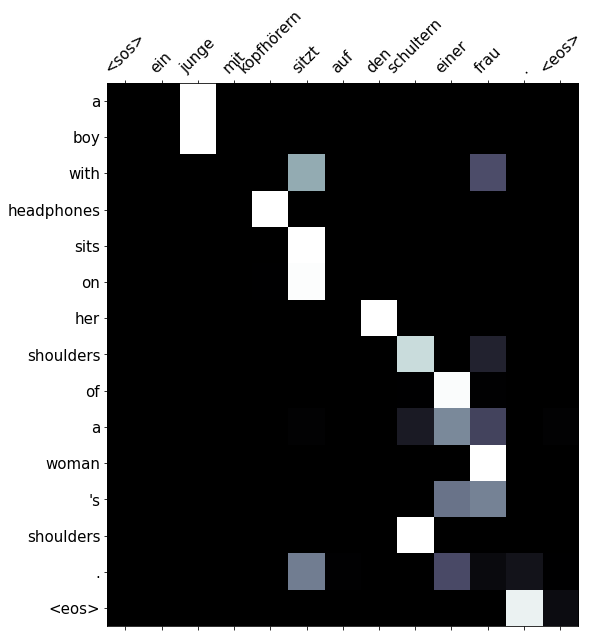

In [30]:
display_attention(src, translation, attention)

Наконец, давайте проверим пример из набора тестов.

In [31]:
example_idx = 4

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['leute', 'reparieren', 'das', 'dach', 'eines', 'hauses', '.']
trg = ['people', 'are', 'fixing', 'the', 'roof', 'of', 'a', 'house', '.']


Получаем здесь правильный по смыслу перевод *are fixing* в *repair*.

In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['people', 'repair', 'the', 'roof', 'of', 'a', 'house', '.', '<eos>']


Внимание вроде правильное. Мы снова привлекли странное внимание к декодированию токена `<eos>`, похоже, он сосредоточен на слове перед точкой. Одно из объяснений может заключаться в том, что модель обращает внимание на последнее слово в предложении, чтобы увидеть, состоит ли входная последовательность из двух предложений, и если нет, она генерирует токен `<eos>`.

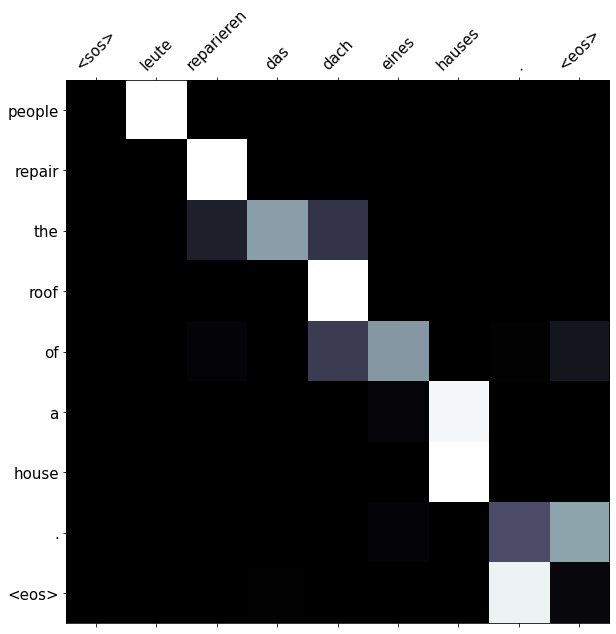

In [33]:
display_attention(src, translation, attention)

## BLEU

Наконец, мы рассчитываем оценку BLEU для модели.

In [34]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

Мы получили оценку BLEU ~ 34 по сравнению с моделью RNN, основанной на внимании, которая дала нам ~ 28. Это улучшение показателя BLEU на ~ 17%.

In [35]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 30.83


Мы рассмотрели первую из наших моделей, не использующих RNN! Далее идет модель «Transformer», в которой даже не используются свёрточные слои — только линейные слои и множество механизмов внимания.

## Обучение сети инвертированию предложения

В конце приведу один из моих любимых тестов: тест на инверсию предложения. Очень простая для человека задача (ученики начальной школы обучаются за 10-15 примеров), но, порой, непреодолима для искусственных систем.

Для Google Colab скачаем обучающие последовательности

In [ ]:
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/train.csv -P toy_revert
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/val.csv -P toy_revert
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/test.csv -P toy_revert

В начале обучим сеть инверсии и посмотрим на результат.


In [56]:
SRC = Field(tokenize="spacy",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True, 
            batch_first = True)

TRG = Field(tokenize="spacy",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True, 
            batch_first = True)

data_fields = [('src', SRC), ('trg', TRG)]
# load the dataset in csv format
train_data, valid_data, test_data = TabularDataset.splits(
    path='toy_revert',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=data_fields,
    skip_header=True
)

SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.src),
     sort_within_batch=True,
     device = device)



################## create DNN Seq2Seq ###############################

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 32
HID_DIM = 64 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

####################################################################


####### initial weights
print(f'The model has {count_parameters(model):,} trainable parameters')
# print(model)


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # writer.add_scalar("Train_loss_average_per_epoch", train_loss, epoch)
    # writer.add_scalar("Validate_loss_average_per_epoch", valid_loss, epoch)

model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


The model has 513,832 trainable parameters
Epoch: 01 | Time: 0m 2s
	Train Loss: 1.246 | Train PPL:   3.476
	 Val. Loss: 0.429 |  Val. PPL:   1.535
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.311 | Train PPL:   1.364
	 Val. Loss: 0.018 |  Val. PPL:   1.019
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.035 | Train PPL:   1.036
	 Val. Loss: 0.026 |  Val. PPL:   1.027
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.045 | Train PPL:   1.046
	 Val. Loss: 0.001 |  Val. PPL:   1.001
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.007 | Train PPL:   1.008
	 Val. Loss: 0.000 |  Val. PPL:   1.000
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.006 | Train PPL:   1.006
	 Val. Loss: 0.003 |  Val. PPL:   1.003
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.000 |  Val. PPL:   1.000
Epoch: 08 | Time: 0m 2s
	Train Loss: 0.001 | Train PPL:   1.001
	 Val. Loss: 0.000 |  Val. PPL:   1.000
Epoch: 09 | Time: 0m 2s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 0.001 |  Val. PPL:   1.001
Epoch: 10 | Time: 0m 

testing with the life example

In [62]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [63]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 20):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

src = ['c', 'b', 'd', 'a', 'd', 'b', 'a', 'c', 'c', 'a', 'b', 'c']
trg = ['c', 'b', 'a', 'c', 'c', 'a', 'b', 'd', 'a', 'd', 'b', 'c']
source        = ['c', 'b', 'd', 'a', 'd', 'b', 'a', 'c', 'c', 'a', 'b', 'c']


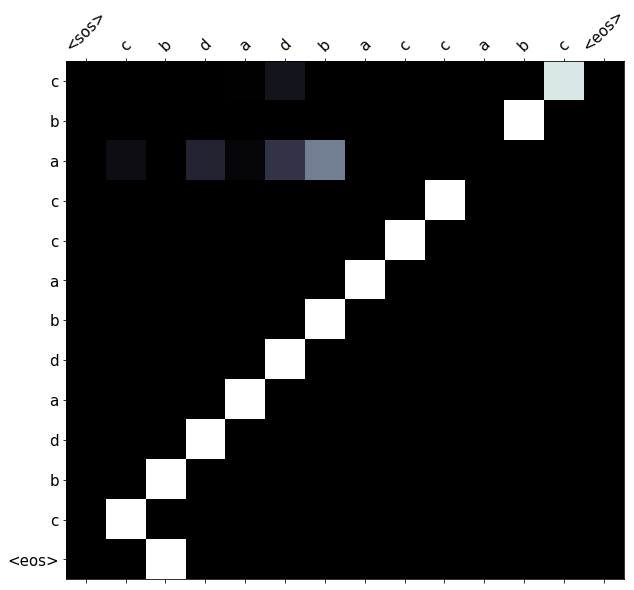

predicted trg = ['c', 'b', 'a', 'c', 'c', 'a', 'b', 'd', 'a', 'd', 'b', 'c', '<eos>']
source        = ['a', 'b', 'c', 'a', 'd']


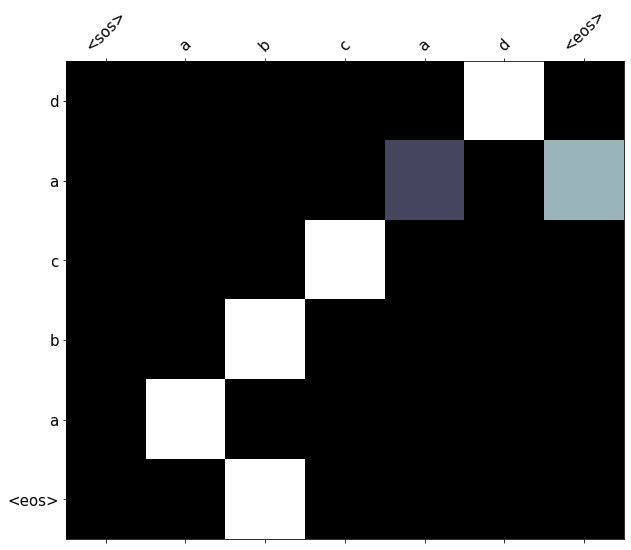

predicted trg = ['d', 'a', 'c', 'b', 'a', '<eos>']
source        = ['d', 'b', 'c', 'd']


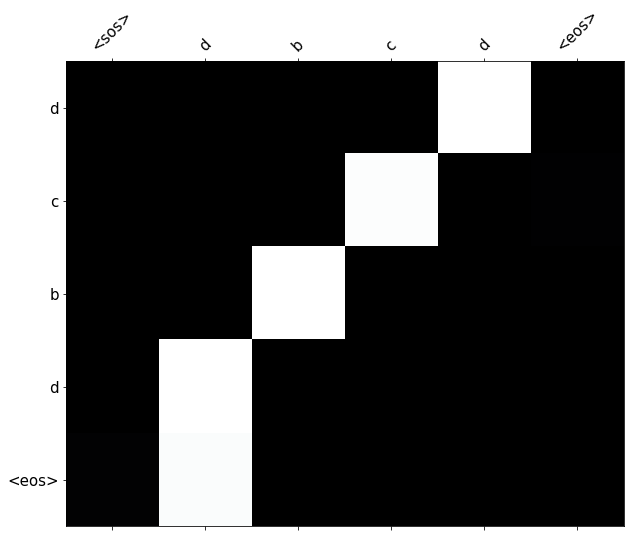

predicted trg = ['d', 'c', 'b', 'd', '<eos>']
source        = ['a', 'a', 'a', 'a', 'd']
predicted trg = ['d', 'a', 'a', 'a', 'a', '<eos>']
source        = ['d', 'b', 'c', 'a']
predicted trg = ['a', 'c', 'b', 'd', '<eos>']
source        = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
predicted trg = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd', '<eos>']
BLEU score = 100.00


In [64]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)

print(f'predicted trg = {translation}')

src = ['a', 'b', 'c', 'a', 'd']
print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)
print(f'predicted trg = {translation}')

src = 'd b c d'.split(' ')
print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)
print(f'predicted trg = {translation}')

src = ['a', 'a', 'a', 'a', 'd']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['d', 'b', 'c', 'a']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')


bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')